In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from FindAreaSSE import display_visualisation, find_use_stations
import geopandas as gpd
import geodatasets

Read in the known SSE events

In [2]:
knownSSE = pd.read_csv("Nishimura/Nishimura2013.csv")
knownSSE = knownSSE[['date', 'lat', 'lon']]
sortedSSE = knownSSE.sort_values(by="date").drop_duplicates().reset_index(drop=True)

startdate = sortedSSE.iloc[0]['date']
enddate = sortedSSE.iloc[sortedSSE.shape[0]-1]['date']
print("----")
print(sortedSSE.head())
print("----")
print("Known SSE start date: ", startdate)
print("Known SSE end date: ", enddate)
print("Numbers of SSE: ", sortedSSE.shape[0])
print("----")

----
         date     lat        lon
0  1996-09-18  33.722  133.13300
1  1996-11-07  34.950  138.29500
2  1997-01-22  34.920  137.01700
3  1997-03-20  33.674  133.23599
4  1997-04-03  33.883  136.03500
----
Known SSE start date:  1996-09-18
Known SSE end date:  2012-01-02
Numbers of SSE:  158
----


Read in the stations

In [3]:
# Choose directory
directory_name = "./japanGNSS"
files = os.listdir(directory_name)

# Process data
GNSSdata = []
stationnames = []

# data range to be used
dates = pd.date_range('1996-12-12', '2020-01-01')

stationsprocessed = 0
for filename in files:
    if filename.endswith(".res"):
        if filename.startswith("._"):
            continue
        # read in file
        path = os.path.join(directory_name, filename)
        GNSSdataframe = pd.read_csv(path, delim_whitespace=True, header=None)

        # parse data
        GNSSdataframe.columns = ["date", "NS_displacement", "EW_displacement", "UD_displacement", "Length_change"]
        GNSSdataframe = GNSSdataframe.drop(columns=["Length_change"])
        GNSSdataframe["date"] = pd.to_datetime(GNSSdataframe["date"])
        GNSSdataframe = GNSSdataframe.set_index("date")

        # Remove double up indexes
        GNSSdataframe = GNSSdataframe.loc[~GNSSdataframe.index.duplicated(), :]

        # reindex to desired time period
        idx = pd.DatetimeIndex(dates)
        GNSSdataframe = GNSSdataframe.reindex(idx)

        # if the number of days missing is too large then drop
        missingdays = GNSSdataframe.shape[0] - GNSSdataframe.dropna().shape[0]
        if missingdays < 200:
            p = GNSSdataframe.interpolate()
            nullremaining = p.shape[0] - p.dropna().shape[0]
            if nullremaining == 0:
                stationsprocessed = stationsprocessed+1
                splitted = filename.split(".")
                stationnames.append(splitted[0])
                GNSSdata.append(p)

print("Stations in array: ", stationsprocessed)

Stations in array:  195


Ensure station data is read correctly

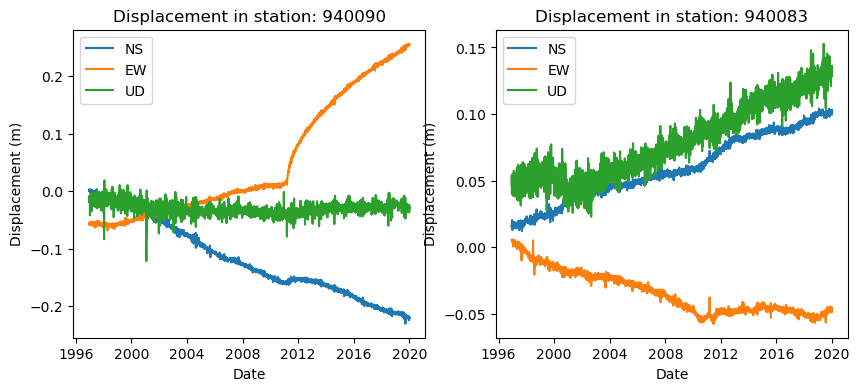

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(GNSSdata[173])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Displacement (m)")
ax[0].set_title("Displacement in station: " + stationnames[172])
ax[0].legend(["NS", "EW", "UD"])

ax[1].plot(GNSSdata[99])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Displacement (m)")
ax[1].set_title("Displacement in station: " + stationnames[99])
ax[1].legend(["NS", "EW", "UD"])

Read in coordinates of each station

In [5]:
# find directory
directory_name_cord = "./japanStationLoc"
files_cord = os.listdir(directory_name_cord)

# Grab relevant files for usable stations
revl_files = []
revl_files_paths = []
for filename in files_cord:
    f_split = filename.split(".")

    if f_split[0] in stationnames:
        revl_files.append(f_split[0])
        path = os.path.join(directory_name_cord, filename)
        revl_files_paths.append(path)

    if "0" + f_split[0] in stationnames:
        revl_files.append("0" + f_split[0])
        path = os.path.join(directory_name_cord, filename)
        revl_files_paths.append(path)

print("Relevant files found: ", len(revl_files))
print("Stations coordinates not found: ", list(set(stationnames) - set(revl_files)))

Relevant files found:  195
Stations coordinates not found:  []


Match station to coordinates

In [6]:
# station location is taken from 2019-01-01 and rounded to 4dp
stationarray = np.empty((0,3))
for i in range(0, len(revl_files)):
    opened_file = open(revl_files_paths[i])
    content = opened_file.readlines()
    line = content[20]
    line = line.split()
    lat = round(float(line[7]), 4)
    lon = round(float(line[8]), 4)
    stationarray = np.append(stationarray, np.array([[revl_files[i], lat, lon]]), axis=0)

stations_cord_df = pd.DataFrame(stationarray, columns=["station", "lat", "lon"])
stations_cord_df["lat"] = stations_cord_df["lat"].astype(float)
stations_cord_df["lon"] = stations_cord_df["lon"].astype(float)

print(stations_cord_df.head())
stations_cord_df.to_csv('/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/clean_raw_data/stations_cords', index=False)

  station      lat       lon
0  950291  35.3717  136.5497
1  950391  35.0209  134.2348
2  940062  35.0947  136.1582
3  950283  35.7578  136.9753
4  940070  33.4834  135.7644


Plot the example stations in 4x4 plot

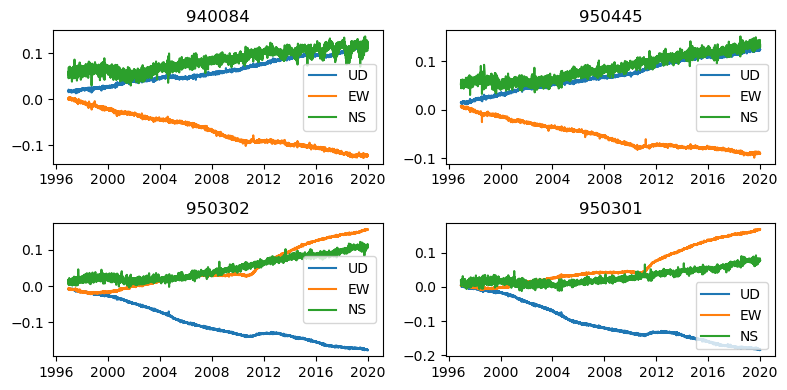

In [7]:
example_stations = ['940084', '950445', '950302', '950301']

fig, ax = plt.subplots(2,2, figsize=(8,4))

positions = [(0,0), (0,1), (1,0), (1,1)]

for i, name in enumerate(example_stations):
    station_data_single = GNSSdata[stationnames.index(name)]
    ax[positions[i]].plot(station_data_single)
    ax[positions[i]].set_title(name)
    ax[positions[i]].legend(["UD", 'EW', "NS"])

fig.tight_layout()

fig.savefig("four_stations.pdf")


Visualisation of station locations and known SSE

/var/folders/j8/pt2nkmns35qcx5khv941ysfm0000gp/T/ipykernel_68678/2970399699.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


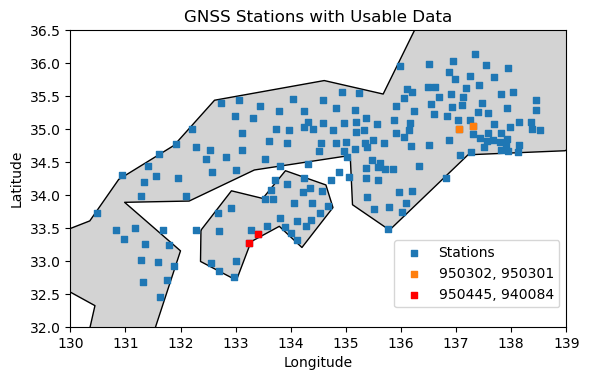

In [8]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
japan = worldmap.loc[worldmap['name'] == 'Japan']
fig, ax = plt.subplots()

ax.set_xlim(130, 139)
ax.set_ylim(32, 36.5)

japan.plot(color='lightgrey', edgecolor="black", ax=ax)

gdf_stations = gpd.GeoDataFrame(
    stations_cord_df, geometry=gpd.points_from_xy(stations_cord_df.lon, stations_cord_df.lat), crs="EPSG:4326"
)

gdf_sse = gpd.GeoDataFrame(
    sortedSSE, geometry=gpd.points_from_xy(sortedSSE.lon, sortedSSE.lat), crs="EPSG:4326"
)

# this code puts a label on every station
# for x, y, label in zip(stations_cord_df.lon, stations_cord_df.lat, stations_cord_df.station):
#     ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points", size=8)

# for x in example_stations:
#     p=stations_cord_df[stations_cord_df['station'] == x]
#     ax.annotate(p['station'].item(), xy=(p.lon.item(), p.lat.item()), xytext=(0, -0.5), textcoords="offset points", size=10)

toplayer = ['950445', '940084'] 
toplayer_df = []
for name_string in toplayer:
    toplayer_df.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])
toplayer_df = pd.DataFrame(toplayer_df)

bottomlayer = ['950302', '950301'] 
bottomlayer_df = []
for name_string in bottomlayer:
    bottomlayer_df.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])
bottomlayer_df = pd.DataFrame(bottomlayer_df)

gdf_stations_top = gpd.GeoDataFrame(
    toplayer_df, geometry=gpd.points_from_xy(toplayer_df.lon, toplayer_df.lat), crs="EPSG:4326"
)

gdf_stations_bottom = gpd.GeoDataFrame(
    bottomlayer_df, geometry=gpd.points_from_xy(bottomlayer_df.lon, bottomlayer_df.lat), crs="EPSG:4326"
)

gdf_stations.plot(marker = "s", markersize = 20, ax=ax)
gdf_stations_bottom.plot(marker = "s", markersize = 20, ax=ax)
gdf_stations_top.plot(marker = "s", markersize = 20, ax=ax, color='red')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("GNSS Stations with Usable Data")
fig.legend(['Stations','950302, 950301', '950445, 940084'], bbox_to_anchor=(0.9, 0.38))
fig.savefig("allstations.pdf")
# gdf_sse.plot(color='red', marker = "^", markersize = 12,alpha=0.4, ax=ax);

Get 3 seperate dataframes, one for each area

In [9]:
area1_selected_stations = ['940086', '950434' ,'950433' ,'950436' ,'950437' ,'950448' ,'950449' ,'940085' ,'940084' ,'950443'] # Area-1
area1_df = []
for name_string in area1_selected_stations:
    area1_df.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])
area1_df = pd.DataFrame(area1_df)

area2_selected_stations = ['950304', '950302', '950306', '950301', '950303', '093102', '093103', '093099', '093050', '093104'] # Area-2
area2_df = []
for name_string in area2_selected_stations:
    area2_df.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])
area2_df = pd.DataFrame(area2_df)


area3_selected_stations = ['950421', '950440', '950441', '950424', '950420', '950423', '950422', '950416', '950418', '950415'] # Area-3
area3_df = []
for name_string in area3_selected_stations:
    area3_df.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])
area3_df = pd.DataFrame(area3_df)


Map with only the areas

/var/folders/j8/pt2nkmns35qcx5khv941ysfm0000gp/T/ipykernel_68678/811405549.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


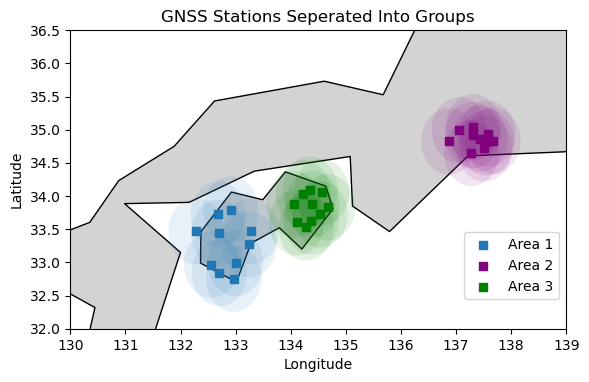

In [10]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
japan = worldmap.loc[worldmap['name'] == 'Japan']
fig, ax = plt.subplots()

ax.set_xlim(130, 139)
ax.set_ylim(32, 36.5)

japan.plot(color='lightgrey', edgecolor="black", ax=ax)

# plot area 1
gdf_stations_area1 = gpd.GeoDataFrame(
    area1_df, geometry=gpd.points_from_xy(area1_df.lon, area1_df.lat), crs="EPSG:4326"
)
gdf_stations_area1_buffer = gpd.GeoDataFrame(
    area1_df, geometry=gpd.points_from_xy(area1_df.lon, area1_df.lat).buffer(0.5), crs="EPSG:4326"
)
gdf_stations_area1_buffer.plot(ax=ax, alpha=0.1)
gdf_stations_area1.plot(ax=ax, marker="s")


#plot area 2
gdf_stations_area2 = gpd.GeoDataFrame(
    area2_df, geometry=gpd.points_from_xy(area2_df.lon, area2_df.lat), crs="EPSG:4326"
)
gdf_stations_area2_buffer = gpd.GeoDataFrame(
    area2_df, geometry=gpd.points_from_xy(area2_df.lon, area2_df.lat).buffer(0.5), crs="EPSG:4326"
)
gdf_stations_area2_buffer.plot(ax=ax, alpha=0.1, color ='purple')
gdf_stations_area2.plot(ax=ax, marker="s", color ='purple')

#plot area 3
gdf_stations_area3 = gpd.GeoDataFrame(
    area3_df, geometry=gpd.points_from_xy(area3_df.lon, area3_df.lat), crs="EPSG:4326"
)
gdf_stations_area3_buffer = gpd.GeoDataFrame(
    area3_df, geometry=gpd.points_from_xy(area3_df.lon, area3_df.lat).buffer(0.5), crs="EPSG:4326"
)
gdf_stations_area3.plot(ax=ax, marker="s", color ='green')
gdf_stations_area3_buffer.plot(ax=ax, alpha=0.1, color ='green')

#plot sse
gdf_sse = gpd.GeoDataFrame(
    sortedSSE, geometry=gpd.points_from_xy(sortedSSE.lon, sortedSSE.lat), crs="EPSG:4326"
)
# gdf_sse.plot(ax=ax, alpha=0.3, marker= "^", color='red')

fig.legend(['Area 1', "Area 2", "Area 3"], bbox_to_anchor=(0.9, 0.4))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("GNSS Stations Seperated Into Groups")
fig.savefig("Groupedstations.pdf")


In [11]:
#
# Takes a GNSSData and returns a GNSS data frame with the origin and the moving average data
#
def moving_average(station, window_size):
    ns_ma = []
    ew_ma = []
    ud_ma = []
    i = 0    

    while i < len(station) - window_size + window_size:
        # window = arr
        if i < window_size:
            ns_ma.append(station.iloc[i]['NS_displacement'])
            ew_ma.append(station.iloc[i]['EW_displacement'])
            ud_ma.append(station.iloc[i]['UD_displacement'])
        else:
            window_ns = station[i: i+window_size]['NS_displacement']
            window_ave_ns = sum(window_ns) / window_size
            ns_ma.append(window_ave_ns)

            window_ew = station[i: i+window_size]['EW_displacement']
            window_ave_ew = sum(window_ew) / window_size
            ew_ma.append(window_ave_ew)

            window_ud = station[i: i+window_size]['UD_displacement']
            window_ave_ud = sum(window_ud) / window_size
            ud_ma.append(window_ave_ud)

        i+=1
    
    station = station.assign(ns_ma = ns_ma)
    station = station.assign(ew_ma = ew_ma)
    station = station.assign(ud_ma = ud_ma)

    return station
    

NS_displacement    float64
EW_displacement    float64
UD_displacement    float64
ns_ma              float64
ew_ma              float64
ud_ma              float64
dtype: object


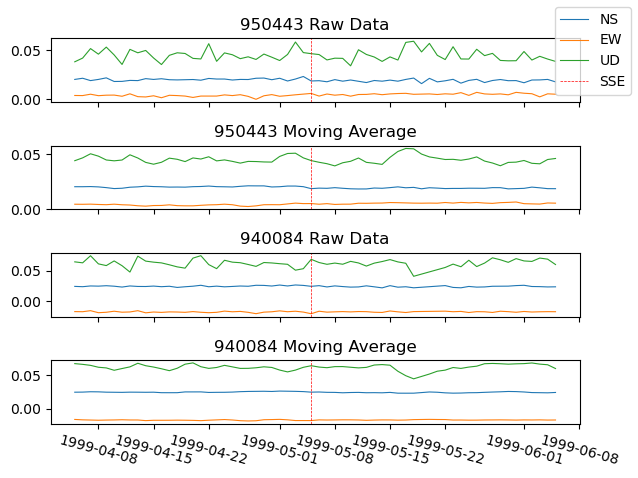

In [19]:
moving_average_size = 3

# get the coordinates of station950443
station950443 = GNSSdata[stationnames.index('950443')]
station950443 = moving_average(station950443, moving_average_size)

# get the coordinates of station940084
station940084 = GNSSdata[stationnames.index('940084')]
station940084 = moving_average(station940084, moving_average_size)

fig, ax = plt.subplots(4,1, sharex='all')

print(station950443.dtypes)

# dates = ["04-08", "04-15", '04-22', '05-01', '05-08', '05-15', '05-22', '06-22']


ax[0].plot(station950443.loc['1999-04-05':'1999-06-05'][['NS_displacement', 'EW_displacement', 'UD_displacement']], linewidth=0.8)
ax[0].axvline(pd.to_datetime('1999-05-05'), linewidth=0.5, color='r', linestyle='--')
ax[0].set_title("950443 Raw Data")
# ax[0].tick_params(axis='x', labelrotation=-30, labelsize=7)
# ax[0].legend(["UD", 'EW', "NS", "SSE"])

ax[1].plot(station950443.loc['1999-04-05':'1999-06-05'][['ns_ma', 'ew_ma', 'ud_ma']], linewidth=0.8)
ax[1].axvline(pd.to_datetime('1999-05-05'), linewidth=0.5, color='r', linestyle='--')
ax[1].set_title("950443 Moving Average")
# ax[1].tick_params(axis='x', labelrotation=-30, labelsize=7)
# ax[1].legend(["UD", 'EW', "NS", "SSE"])

ax[2].plot(station940084.loc['1999-04-05':'1999-06-05'][['NS_displacement', 'EW_displacement', 'UD_displacement']], linewidth=0.8)
ax[2].axvline(pd.to_datetime('1999-05-05'), linewidth=0.5, color='r', linestyle='--')
ax[2].set_title("940084 Raw Data")
# ax[2].tick_params(axis='x', labelrotation=-30, labelsize=7)
# ax[2].legend(["UD", 'EW', "NS", "SSE"])

ax[3].plot(station940084.loc['1999-04-05':'1999-06-05'][['ns_ma', 'ew_ma', 'ud_ma']], linewidth=0.8)
ax[3].axvline(pd.to_datetime('1999-05-05'), linewidth=0.5, color='r', linestyle='--')
ax[3].set_title("940084 Moving Average")
ax[3].tick_params(axis='x', labelrotation=-15)
# ax[3].legend(["UD", 'EW', "NS", "SSE"])
# ax[1,1].set_xticks(range(0,len(dates)), dates)

fig.legend(["NS", "EW", "UD", "SSE"])
fig.tight_layout()
fig.savefig("SSEexample.pdf", bbox_inches='tight')

In [13]:
range(0,len(dates))

range(0, 8)